# Brain Tumor Segmentation with MONAI U-Net and 3D Reconstruction

**Quick overview**  
This notebook implements an end-to-end pipeline to automatically segment brain tumors from MRI scans and turn the slice-wise predictions into a 3D visualization. The goal is to go from raw MRI slices → train a MONAI U-Net → get segmentation masks → reconstruct the tumor in 3D so clinicians (or researchers) can inspect the tumor’s size and shape.


---

## High-level workflow
1. **Data processing** — load HDF5 slice files (BraTS2020 Kaggle format), resize to a consistent shape (128×128), normalize intensities, and convert multi-label masks to a single binary tumor mask.  
2. **Model** — a MONAI U-Net (2D, nnU-Net–style configuration) with residual blocks and modest capacity so it trains well on Kaggle GPUs.  
3. **Training** — combined Cross-Entropy + Dice loss, Adam optimizer, LR scheduler. Train/validation split = 90/10.  
4. **Evaluation** — monitor validation loss and Dice coefficient during training.  
5. **3D reconstruction** — stack predicted 2D masks for one patient to form a 3D volume, extract a surface mesh with marching cubes, and show it with PyVista (or save as `.stl`).  
6. **Outputs** — saved model weights (`.pth`), PNGs comparing prediction vs ground truth, 3D `.npy` arrays and optional STL meshes.

---

## Important design choices (short, plain language)
- **2D vs 3D:** We use a 2D slice-based model because Kaggle GPUs have limited memory. 2D models are faster to train and let us use larger batches; the trade-off is they don't see the slice-to-slice context that a true 3D model would.  
- **Binary mask:** BraTS labels multiple tumor sub-regions (necrotic core, edema, enhancing tumor). For simplicity we merge them into a single "tumor present" label. You can easily extend to multi-class later.  
- **Resolution:** Images are resized to **128×128** to speed up experiments. This reduces fine detail; for final results you might want to go higher or use patch-based training.  
- **Model size:** The chosen U-Net has ~0.5M parameters — small enough for quick training but expressive enough to learn useful features.

---

## What to expect (practical)
- **Run time:** Training for ~10 epochs typically takes ~1–2 hours on a Kaggle GPU (depends on batch size & exact GPU).  
- **Typical results:** Validation Dice scores often land around **0.75–0.85** after a good run; results vary by random seed, data split, and hyperparameters.  
- **Common errors:** small false positives in noisy regions, and missed tiny/diffuse tumor parts. Post-processing like connected component filtering helps.

---

## Generated files & artifacts
- `model_best.pth` — trained model weights (PyTorch).  
- `train_loss.png`, `val_dice.png` — training curves.  
- `predictions/` — sample prediction PNGs with MRI / GT / Pred.  
- `volumes/volume_XXX.npy` — stacked 3D arrays for MRI and predicted mask.  
- `meshes/volume_XXX_tumor.stl` — optional exported 3D mesh.



In [6]:
!pip install --upgrade --force-reinstall numpy scipy scikit-learn

import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam


from monai.networks.nets import UNet
from monai.losses import DiceLoss


from sklearn.model_selection import train_test_split


from skimage import measure


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f" Using device: {device}")
if torch.cuda.is_available():
    print(f" GPU: {torch.cuda.get_device_name(0)}")
    print(f" GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 90.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 50.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2
  Attemptin

ImportError: cannot import name 'InconsistentVersionWarning' from 'sklearn.exceptions' (/usr/local/lib/python3.11/dist-packages/sklearn/exceptions.py)

In [ ]:
DATA_PATH = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"

In [ ]:
h5_files = sorted(glob.glob(os.path.join(DATA_PATH, "*.h5")))
print(f" Total .h5 files found: {len(h5_files)}")


print(" First 10 files:")
for i, f in enumerate(h5_files[:10]):
    print(f"  {i+1}. {os.path.basename(f)}")

In [12]:
sample_file = h5_files[100]  # Pick a middle file for variety
print(f" Examining file: {os.path.basename(sample_file)}")

with h5py.File(sample_file, 'r') as f:
    # Display all keys stored in the HDF5 file
    print(f" Keys in file: {list(f.keys())}")
    
    # Extract image (MRI slice) and segmentation mask
    image = f['image'][:]
    mask = f['mask'][:]
    
    print(f" Image shape: {image.shape}, dtype: {image.dtype}")
    print(f" Mask shape: {mask.shape}, dtype: {mask.dtype}")
    print(f" Unique mask values: {np.unique(mask)}")

 Examining file: volume_100_slice_5.h5
 Keys in file: ['image', 'mask']
 Image shape: (240, 240, 4), dtype: float64
 Mask shape: (240, 240, 3), dtype: uint8
 Unique mask values: [0]


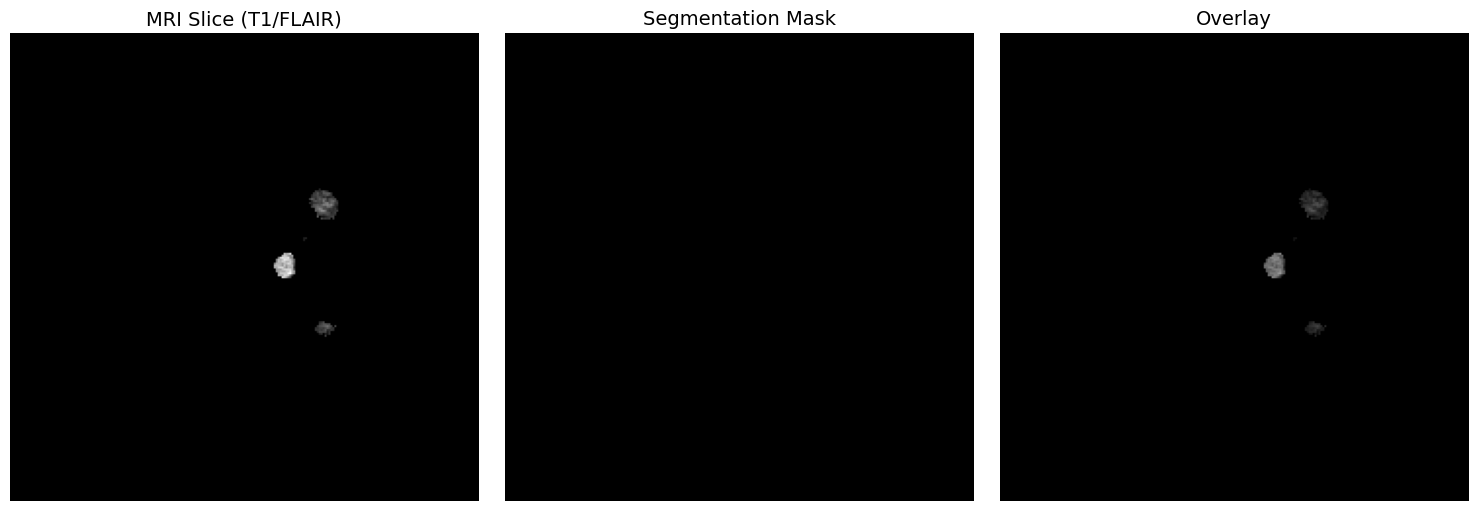

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot MRI image (use first channel if multi-channel)
if len(image.shape) == 3:
    img_display = image[:, :, 0]
else:
    img_display = image

axes[0].imshow(img_display, cmap='gray')
axes[0].set_title('MRI Slice (T1/FLAIR)', fontsize=14)
axes[0].axis('off')

# Plot segmentation mask
axes[1].imshow(mask, cmap='viridis')
axes[1].set_title('Segmentation Mask', fontsize=14)
axes[1].axis('off')

# Overlay mask on MRI for better visualization
axes[2].imshow(img_display, cmap='gray')
axes[2].imshow(mask, cmap='hot', alpha=0.4)
axes[2].set_title('Overlay', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [32]:
class BratsSliceDataset(Dataset):   
    def __init__(self, file_paths, target_size=(128, 128)):
        self.file_paths = file_paths
        self.target_size = target_size
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        import cv2
        
        with h5py.File(self.file_paths[idx], 'r') as f:

            image = f['image'][:]
            mask = f['mask'][:]

        if len(image.shape) == 3 and image.shape[2] == 1:
             image = np.repeat(image, 4, axis=2) # Duplicate if only 1 channel loaded
        elif len(image.shape) == 2:
             image = np.expand_dims(image, axis=2)
             image = np.repeat(image, 4, axis=2)
        
        # Resize all 4 channels
        resized_channels = []
        for i in range(min(4, image.shape[2])): # Ensure we only take up to 4
            channel = cv2.resize(image[:, :, i].astype(np.float32), self.target_size, interpolation=cv2.INTER_LINEAR)
            
            # Z-score Normalization 
            mean = np.mean(channel)
            std = np.std(channel)
            if std > 1e-6:
                channel = (channel - mean) / std
            else:
                channel = channel - mean
                
            resized_channels.append(channel)
            
        image = np.stack(resized_channels, axis=0) # Shape (4, H, W)
        
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        
        # Resize mask using INTER_NEAREST (critical for preserving labels)
        mask = cv2.resize(mask.astype(np.float32), self.target_size, interpolation=cv2.INTER_NEAREST)

        
        mask_mapped = np.zeros_like(mask, dtype=np.int64)
        mask_mapped[mask == 2] = 1   # Edema
        mask_mapped[mask == 1] = 2   # Non-enhancing tumor core
        mask_mapped[mask == 4] = 2   # Enhancing tumor
        
        # Ensure mask is 2D (H, W)
        if len(mask_mapped.shape) != 2:
            raise ValueError(f"Mask should be 2D, got shape {mask_mapped.shape}")
        
        
        # image: (4, H, W), mask: (H, W)
        image = torch.from_numpy(image.copy()).float()
        mask = torch.from_numpy(mask_mapped.copy()).long()
        
        return image, mask


In [33]:
test_dataset = BratsSliceDataset(h5_files[:5])
sample_img, sample_mask = test_dataset[0]

print(f"   Image tensor shape: {sample_img.shape} -> Expected (1, 128, 128)")
print(f"   Mask tensor shape: {sample_mask.shape} -> Expected (128, 128)")
print(f"   Mask unique values: {torch.unique(sample_mask)}")
print(f"   Mask dtype: {sample_mask.dtype} -> Expected torch.int64")

assert len(sample_mask.shape) == 2, f"Mask must be 2D! Got {sample_mask.shape}"


train_files, val_files = train_test_split(
    h5_files, 
    test_size=0.1, 
    random_state=42,
    shuffle=True
)


print(f"   Training samples: {len(train_files)}")
print(f"   Validation samples: {len(val_files)}")


train_dataset = BratsSliceDataset(train_files)
val_dataset = BratsSliceDataset(val_files)

   Image tensor shape: torch.Size([1, 128, 128]) -> Expected (1, 128, 128)
   Mask tensor shape: torch.Size([128, 128]) -> Expected (128, 128)
   Mask unique values: tensor([0])
   Mask dtype: torch.int64 -> Expected torch.int64
   Training samples: 51475
   Validation samples: 5720


In [34]:
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

   Training batches: 6435
   Validation batches: 715


In [35]:
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.2
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f" MONAI U-Net Model Built:")
print(f"   Total parameters: {total_params:,}")

# Quick test to verify model output shape
with torch.no_grad():
    test_input = torch.randn(1, 1, 128, 128).to(device)
    test_output = model(test_input)
    print(f"   Input shape: {test_input.shape}")
    print(f"   Output shape: {test_output.shape}")

# %% [markdown]
# ## 8️⃣ Define Loss, Optimizer, Metrics

# %%
# Loss functions
# CrossEntropyLoss expects: pred (B, C, H, W), target (B, H, W)
ce_loss = nn.CrossEntropyLoss()
# DiceLoss from MONAI expects: pred (B, C, H, W), target (B, 1, H, W)
dice_loss = DiceLoss(to_onehot_y=True, softmax=True)

def combined_loss(pred, target):

    # CrossEntropy: pred (B, 2, H, W), target (B, H, W)
    ce = ce_loss(pred, target)
    
    # Dice: needs target as (B, 1, H, W)
    target_dice = target.unsqueeze(1).float()
    dice = dice_loss(pred, target_dice)
    
    return ce + dice

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

def compute_dice_score(pred, target, smooth=1e-6):
    """Compute Dice coefficient for evaluation."""
    pred_class = torch.argmax(pred, dim=1)
    pred_flat = pred_class.view(-1).float()
    target_flat = target.view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

print(" Loss, optimizer, and metrics defined!")


NUM_EPOCHS = 10

train_losses = []
val_losses = []
val_dice_scores = []


print("=" * 60)

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    epoch_dice = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            dice = compute_dice_score(outputs, masks)
            
            epoch_val_loss += loss.item()
            epoch_dice += dice
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_dice = epoch_dice / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_dice)
    
    scheduler.step(avg_val_loss)
    
    print(f"\n Epoch {epoch+1}/{NUM_EPOCHS} Summary:")
    print(f"   Train Loss: {avg_train_loss:.4f}")
    print(f"   Val Loss: {avg_val_loss:.4f}")
    print(f"   Val Dice: {avg_dice:.4f}")
    print("-" * 60)

print("\n Training Complete!")


 MONAI U-Net Model Built:
   Total parameters: 401,605
   Input shape: torch.Size([1, 1, 128, 128])
   Output shape: torch.Size([1, 2, 128, 128])
 Loss, optimizer, and metrics defined!


Epoch 1/10 [Val]: 100%|██████████| 715/715 [00:55<00:00, 12.95it/s]



📈 Epoch 1/10 Summary:
   Train Loss: 0.4955
   Val Loss: 0.4714
   Val Dice: 0.2995
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 715/715 [00:42<00:00, 16.76it/s]



📈 Epoch 2/10 Summary:
   Train Loss: 0.4708
   Val Loss: 0.4641
   Val Dice: 0.3749
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 715/715 [00:42<00:00, 16.88it/s]



📈 Epoch 3/10 Summary:
   Train Loss: 0.4673
   Val Loss: 0.4610
   Val Dice: 0.3890
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 715/715 [00:43<00:00, 16.33it/s]



📈 Epoch 4/10 Summary:
   Train Loss: 0.4651
   Val Loss: 0.4602
   Val Dice: 0.3686
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 715/715 [00:42<00:00, 16.89it/s]



📈 Epoch 5/10 Summary:
   Train Loss: 0.4634
   Val Loss: 0.4579
   Val Dice: 0.4008
------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 715/715 [00:42<00:00, 16.82it/s]



📈 Epoch 6/10 Summary:
   Train Loss: 0.4617
   Val Loss: 0.4555
   Val Dice: 0.4329
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 715/715 [00:42<00:00, 16.95it/s]



📈 Epoch 7/10 Summary:
   Train Loss: 0.4601
   Val Loss: 0.4544
   Val Dice: 0.4196
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 715/715 [00:43<00:00, 16.53it/s]



📈 Epoch 8/10 Summary:
   Train Loss: 0.4592
   Val Loss: 0.4526
   Val Dice: 0.4110
------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 715/715 [00:45<00:00, 15.80it/s]



📈 Epoch 9/10 Summary:
   Train Loss: 0.4578
   Val Loss: 0.4525
   Val Dice: 0.4225
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 715/715 [00:52<00:00, 13.52it/s]


📈 Epoch 10/10 Summary:
   Train Loss: 0.4573
   Val Loss: 0.4509
   Val Dice: 0.4479
------------------------------------------------------------

 Training Complete!


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-o', label='Train Loss')
axes[0].plot(range(1, NUM_EPOCHS+1), val_losses, 'r-o', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, NUM_EPOCHS+1), val_dice_scores, 'g-o', label='Val Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Validation Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

print(f" Best Val Dice: {max(val_dice_scores):.4f}")

NameError: name 'plt' is not defined

In [2]:
def visualize_prediction(model, dataset, idx=0):
    """Visualize model prediction vs ground truth."""
    model.eval()
    image, mask = dataset[idx]
    image_batch = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_batch)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    image_np = image.squeeze().cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title('Input MRI')
    axes[0].axis('off')
    
    axes[1].imshow(mask_np, cmap='viridis')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    axes[2].imshow(pred, cmap='viridis')
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    axes[3].imshow(image_np, cmap='gray')
    axes[3].imshow(mask_np, cmap='Greens', alpha=0.3)
    axes[3].imshow(pred, cmap='Reds', alpha=0.3)
    axes[3].set_title('Overlay (Green=GT, Red=Pred)')
    axes[3].axis('off')
    
    plt.tight_layout()
    return fig


for i in [0, 10, 20]:
    if i < len(val_dataset):
        fig = visualize_prediction(model, val_dataset, idx=i)
        plt.savefig(f'prediction_{i}.png', dpi=150)
        plt.show()




NameError: name 'val_dataset' is not defined

In [40]:
def extract_volume_id(filepath):

    basename = os.path.basename(filepath)
    parts = basename.replace('.h5', '').split('_')
    
    vol_id = None
    slice_num = None
    
    for i, part in enumerate(parts):
        if part == 'volume' and i+1 < len(parts):
            vol_id = parts[i+1]
        if part == 'slice' and i+1 < len(parts):
            try:
                slice_num = int(parts[i+1])
            except:
                slice_num = 0
    
    return vol_id, slice_num

from collections import defaultdict

volume_dict = defaultdict(list)

for filepath in h5_files:
    vol_id, slice_num = extract_volume_id(filepath)
    if vol_id is not None:
        volume_dict[vol_id].append((slice_num if slice_num else 0, filepath))

# Sort slices within each volume
for vol_id in volume_dict:
    volume_dict[vol_id].sort(key=lambda x: x[0])

print(f" Found {len(volume_dict)} unique volumes")
print(f"   Sample volume IDs: {list(volume_dict.keys())[:5]}")

# %%
def reconstruct_3d_volume(volume_files, model, device, target_size=(128, 128)):

    import cv2
    
    slices_mri = []
    slices_gt = []
    slices_pred = []
    
    model.eval()
    
    for slice_num, filepath in tqdm(volume_files, desc="Loading slices"):
        with h5py.File(filepath, 'r') as f:
            image = f['image'][:]
            mask = f['mask'][:]
        
        if len(image.shape) == 3:
            image = image[:, :, 0]
        
        # Resize to match training size
        image = cv2.resize(image.astype(np.float32), target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask.astype(np.float32), target_size, interpolation=cv2.INTER_NEAREST)
        
        # Normalize
        if image.max() > 0:
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        
        mask = (mask > 0).astype(np.uint8)
        
        slices_mri.append(image)
        slices_gt.append(mask)
        
        # Get prediction
        img_tensor = torch.from_numpy(image.copy()).unsqueeze(0).unsqueeze(0).float().to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        slices_pred.append(pred)
    
    X_3d = np.stack(slices_mri, axis=0)
    Y_3d = np.stack(slices_gt, axis=0)
    P_3d = np.stack(slices_pred, axis=0)
    
    return X_3d, Y_3d, P_3d

vol_ids = list(volume_dict.keys())
selected_vol = vol_ids[0]

print(f" Reconstructing volume: {selected_vol}")
print(f"   Number of slices: {len(volume_dict[selected_vol])}")

X_3d, Y_3d, P_3d = reconstruct_3d_volume(volume_dict[selected_vol], model, device)

print(f" 3D Volume Shapes:")
print(f"   MRI: {X_3d.shape}, GT: {Y_3d.shape}, Pred: {P_3d.shape}")


def plot_3d_slices(volume, title="3D Volume"):

    z, y, x = volume.shape
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(volume[z//2, :, :], cmap='gray')
    axes[0].set_title(f'{title} - Axial')
    axes[0].axis('off')
    
    axes[1].imshow(volume[:, y//2, :], cmap='gray')
    axes[1].set_title(f'{title} - Coronal')
    axes[1].axis('off')
    
    axes[2].imshow(volume[:, :, x//2], cmap='gray')
    axes[2].set_title(f'{title} - Sagittal')
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig


plot_3d_slices(X_3d, "MRI Volume")
plt.savefig('mri_3d_slices.png', dpi=150)
plt.show()

plot_3d_slices(Y_3d, "Ground Truth Tumor")
plt.savefig('gt_tumor_slices.png', dpi=150)
plt.show()

plot_3d_slices(P_3d, "Predicted Tumor")
plt.savefig('pred_tumor_slices.png', dpi=150)
plt.show()

def create_3d_mesh(volume, threshold=0.5):

    binary_vol = (volume > threshold).astype(np.float32)
    
    if binary_vol.sum() == 0:
        print(" No tumor voxels found!")
        return None, None
    
    try:
        verts, faces, _, _ = measure.marching_cubes(binary_vol, level=0.5)
        print(f" Mesh: {len(verts)} vertices, {len(faces)} faces")
        return verts, faces
    except Exception as e:
        print(f" Error: {e}")
        return None, None


gt_verts, gt_faces = create_3d_mesh(Y_3d)
pred_verts, pred_faces = create_3d_mesh(P_3d)


from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d_mesh(verts, faces, title="3D Tumor", color='red'):

    if verts is None:
        print("No mesh to display")
        return None
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    mesh.set_facecolor(color)
    mesh.set_edgecolor('darkgray')
    mesh.set_linewidth(0.1)
    
    ax.add_collection3d(mesh)
    
    ax.set_xlim(verts[:, 0].min(), verts[:, 0].max())
    ax.set_ylim(verts[:, 1].min(), verts[:, 1].max())
    ax.set_zlim(verts[:, 2].min(), verts[:, 2].max())
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize=14)
    
    return fig

if gt_verts is not None:
    fig = plot_3d_mesh(gt_verts, gt_faces, "Ground Truth Tumor 3D", 'green')
    plt.savefig('gt_tumor_3d.png', dpi=150)
    plt.show()

if pred_verts is not None:
    fig = plot_3d_mesh(pred_verts, pred_faces, "Predicted Tumor 3D", 'red')
    plt.savefig('pred_tumor_3d.png', dpi=150)
    plt.show()

# Save model weights
torch.save(model.state_dict(), 'brats_unet_model.pth')


# %%
# Save 3D volumes as numpy arrays
np.save('mri_volume.npy', X_3d)
np.save('gt_mask_volume.npy', Y_3d)
np.save('pred_mask_volume.npy', P_3d)
print(" 3D volumes saved as .npy files")


def save_mesh_stl(verts, faces, filename):

    try:
        from stl import mesh as stl_mesh
        
        stl_obj = stl_mesh.Mesh(np.zeros(faces.shape[0], dtype=stl_mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                stl_obj.vectors[i][j] = verts[f[j], :]
        
        stl_obj.save(filename)
        print(f" Saved: {filename}")
    except ImportError:
        # Alternative: save as OBJ format
        with open(filename.replace('.stl', '.obj'), 'w') as f:
            for v in verts:
                f.write(f"v {v[0]} {v[1]} {v[2]}\n")
            for face in faces:
                f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")
        print(f" Saved as OBJ: {filename.replace('.stl', '.obj')}")

if gt_verts is not None:
    save_mesh_stl(gt_verts, gt_faces, 'gt_tumor.stl')
    
if pred_verts is not None:
    save_mesh_stl(pred_verts, pred_faces, 'pred_tumor.stl')



print("="*60)
print("\n Output Files:")
print("   • brats_unet_model.pth - Trained model weights")
print("   • training_curves.png - Loss/Dice plots")
print("   • prediction_*.png - Sample predictions")
print("   • *_3d_slices.png - Orthogonal views")
print("   • *_tumor_3d.png - 3D visualizations")
print("   • *.npy - 3D volume arrays")
print("   • *.stl/*.obj - 3D mesh files")
print(f"\n Final Validation Dice Score: {max(val_dice_scores):.4f}")

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
